In [ ]:
'''Interactive run file for the G2-structure learning'''
#...ensure this notebook is using the correct kernel for your virtual environment
# Import libraries
import os
import yaml
import numpy as np
import tensorflow as tf

# Import functions
from models.model import (
    GlobalModel, TrainingModel, NormalisationLayer, 
    DenormalisationLayer, NormalisedModel, ScaledGlorotUniform
)
from sampling.sampling import LinkSample
from geometry.compression import form_to_vec, vec_to_form, vec_to_metric
from geometry.geometry import exterior_derivative, holomorphic_volume_form_to_real
from geometry.wedge import wedge
# NOTE: patch_indices_to_scalar is DEPRECATED - now using 2D patch vectors [one_idx, dropped_idx]

# Print the hyperparameters
with open(os.getcwd()+'/hyperparameters/hps.yaml', "r") as file:
    hp = yaml.safe_load(file)
print(f'Run hyperparameters:\t...edit in hyperparameters/hps.yaml\n{hp}')

Run hyperparameters:	...edit in hyperparameters/hps.yaml
{'metric': False, 'num_samples': 500000, 'target_patch': [0, 1], 'saved_model': False, 'saved_model_path': '...', 'n_hidden': 256, 'n_layers': 4, 'activations': 'gelu', 'use_bias': True, 'parameter_initialisation_scale': 1.0, 'embedding_dim': 8, 'dropout_rate': 0.1, 'l2_regularization': 0.0001, 'epochs': 300, 'n_data_resamples': 20, 'batch_size': 512, 'init_learning_rate': 0.001, 'min_learning_rate': 0.0001, 'validate': True, 'val_print': False, 'num_val_samples': 5000, 'val_batch_size': 500, 'verbosity': 1, 'print_losses': False, 'print_interval': 1}


In [ ]:
# Code for running the cymetric training script
# ...we recommend just using the pre-trained Calabi-Yau metric in the repo and skipping this cell.
#!python3 -m models.cy_model

In [ ]:
# Run the training script
model_name = 'test'
!python3 -m run {model_name}

In [2]:
# Import the trained model
loaded_model_name = '3form_1patch' #model_name #...or set to desired name if not model trained above
loaded_model_path = os.getcwd() + f"/runs/global_model_{loaded_model_name}.keras" #...reimport the model
#loaded_model_path = os.getcwd() + f"/models/link_models/global_model_3form.keras" #...import a pre-trained model instead

# Custom objects for loading the new architecture
custom_objects = {
    'GlobalModel': GlobalModel,
    'NormalisationLayer': NormalisationLayer,
    'DenormalisationLayer': DenormalisationLayer,
    'NormalisedModel': NormalisedModel,
    'ScaledGlorotUniform': ScaledGlorotUniform
}

# Load the model
loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects=custom_objects)

/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'global_model' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


In [19]:
# Test loaded model on fake link points
# Testing hyperparameters
testsize = 1000 #...how many link points to use in the testing

# Optional: Set target_patch to filter for specific patch, or None for all patches
# Examples: target_patch = (0, 1) for one_idx=0, dropped_idx=1
#           target_patch = None for all patches (mixed)
target_patch = [0,1]  # Change to (one_idx, dropped_idx) to test specific patch

# Generate the testing data on the Link
test_dataset = LinkSample(testsize, target_patch=target_patch)
test_linkpts = test_dataset.link_points()
# NEW: Use 2D patch vectors [one_idx, dropped_idx] instead of scalar encoding
test_patch_idxs = tf.stack([test_dataset.one_idxs, test_dataset.dropped_idxs], axis=1)

if target_patch is not None:
    print(f'Generated {testsize} samples for patch {target_patch}')
else:
    # Show patch distribution when using mixed patches
    unique_patches = tf.unique(test_dataset.one_idxs * 5 + test_dataset.dropped_idxs)[0]
    print(f'Generated {testsize} samples across {len(unique_patches)} different patches')

if not hp["metric"]:
    test_link_outputs = test_dataset.g2_form
else:
    test_link_outputs = test_dataset.g2_metric
test_linkpts_tf = tf.convert_to_tensor(test_linkpts)
test_link_outputs_tf = tf.convert_to_tensor(test_link_outputs)
    
# Compute the NN test outputs using the new GlobalModel interface
if not hp["metric"]:
    # Compute the predicted G2 3-forms (loaded_model returns at original scale)
    predicted_g2form_vecs = np.array(loaded_model([test_linkpts_tf, test_patch_idxs]))
    predicted_g2forms = np.array(vec_to_form(predicted_g2form_vecs, 7, 3).numpy())
    print(f'G2 3-forms computed... (shape: {predicted_g2forms.shape})')
else:
    # Compute the predicted G2 metrics (loaded_model returns at original scale)
    predicted_g2metric_vecs = np.array(loaded_model([test_linkpts_tf, test_patch_idxs]))
    predicted_g2metrics = np.array(vec_to_metric(predicted_g2metric_vecs, 7, 3).numpy())
    print(f'G2 metrics computed... (shape: {predicted_g2metrics.shape})')

/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
pointgen:INFO:Vol_k: 5.0, Vol_cy: 280.4873248050895.


  Filtering train for patch [0, 1]: 273/5000 → 273/1000


pointgen:INFO:Vol_k: 5.0, Vol_cy: 285.7780711683532.


    Iteration 2: 263/5000 → 536/1000


pointgen:INFO:Vol_k: 5.0, Vol_cy: 283.3381947212776.


    Iteration 3: 249/5000 → 785/1000


pointgen:INFO:Vol_k: 5.0, Vol_cy: 284.2416690016656.


    Iteration 4: 234/5000 → 1019/1000
Generated 1000 samples for patch [0, 1]
G2 3-forms computed... (shape: (1000, 7, 7, 7))


In [ ]:
# More loss testing
test_outputs_vecs = form_to_vec(test_link_outputs_tf)
print(test_outputs_vecs.shape, predicted_g2form_vecs.shape)

# Mask out near-zero components for evaluation
def robust_metrics(y_true, y_pred, threshold=0.0001):
    mask = np.abs(y_true) > threshold
    if np.sum(mask) > 0:
        active_true = y_true[mask]
        active_pred = y_pred[mask]
        
        mae_active = np.mean(np.abs(active_true - active_pred))
        mape_active = 100 * np.mean(np.abs(active_true - active_pred) / np.abs(active_true))
        
        return mae_active, mape_active, np.sum(mask)
    return None, None, 0

# Define losses
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mape = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

# Compute losses
mae_loss = mae(test_outputs_vecs, predicted_g2form_vecs).numpy()
mse_loss = mse(test_outputs_vecs, predicted_g2form_vecs).numpy()
mape_loss = mape(test_outputs_vecs, predicted_g2form_vecs).numpy()
mae_active, mape_active, n_active = robust_metrics(
    test_outputs_vecs.numpy().flatten(), 
    predicted_g2form_vecs.flatten()
)

# Print losses
print("(MAE, MSE, MAPE):", (mae_loss, mse_loss, mape_loss))
print(f"Active components: {n_active}/{np.prod(test_outputs_vecs.shape)}")
print(f"Active MAE: {mae_active:.6f}")
print(f"Active MAPE: {mape_active:.2f}%")


(1000, 35) (1000, 35)
(MAE, MSE, MAPE): (0.15253001, 0.1272768, 9363.546)
Active components: 13930/35000
Active MAE: 0.380608
Active MAPE: 10656.40%


Mean absolute values per component:
[1.0510953e-02 7.9537488e-38 1.8853664e-38 1.0367020e-02 1.4158745e-38
 1.9822266e-38 1.0553880e-02 1.1880682e-38 4.0325211e-38 2.2171171e-38
 3.0827980e-38 1.4913448e-07 9.9658258e-03 5.0900191e-01 8.1337422e-01
 9.8577347e-03 4.9348726e-38 1.8330567e-38 5.2087239e-38 1.6650559e-38
 1.0155026e-02 5.0899231e-01 1.6982315e-38 1.7212274e-38 7.4417531e-01
 1.0551177e-02 4.2464495e-38 8.1342006e-01 3.9672506e-38 7.4419385e-01
 7.3971962e-38 1.0152112e-02 9.9896045e-38 8.8218011e-38 3.7344293e-38]


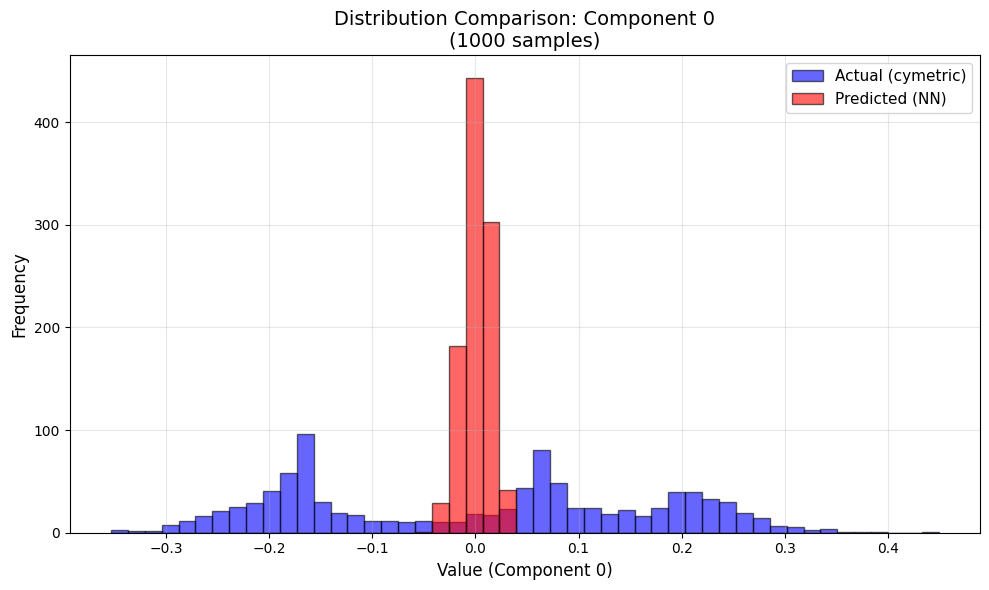


Component 0 Distribution Statistics:
Actual:    mean=0.001243, std=0.173480
Predicted: mean=0.001153, std=0.013156
Mean difference: 0.000090
Std difference: 0.160324


In [42]:
########################################################################################
### Component Testing ###
########################################################################################

# Mean absolute values per component
mean_abs_per_component = np.mean(np.absolute(predicted_g2form_vecs), axis=0)
print("Mean absolute values per component:")
print(mean_abs_per_component)

# Select which component to visualize (change this to any value 0-34)
hist_component_idx = 0
# Zero components: [1, 2, 4, 5, 7, 8, 9, 10, 11, 16, 17, 18, 19, 22, 23, 26, 28, 30, 32, 33, 34]

# Extract the selected component from all samples
actual_component = test_outputs_vecs[:, hist_component_idx].numpy()
predicted_component = predicted_g2form_vecs[:, hist_component_idx]

# Create shared bins based on the combined data range
combined_data = np.concatenate([actual_component, predicted_component])
bins = np.linspace(combined_data.min(), combined_data.max(), 50)

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(actual_component, bins=bins, alpha=0.6, label='Actual (cymetric)', color='blue', edgecolor='black')
plt.hist(predicted_component, bins=bins, alpha=0.6, label='Predicted (NN)', color='red', edgecolor='black')

plt.xlabel(f'Value (Component {hist_component_idx})', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution Comparison: Component {hist_component_idx}\n({len(actual_component)} samples)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print distribution statistics
print(f"\nComponent {hist_component_idx} Distribution Statistics:")
print(f"Actual:    mean={actual_component.mean():.6f}, std={actual_component.std():.6f}")
print(f"Predicted: mean={predicted_component.mean():.6f}, std={predicted_component.std():.6f}")
print(f"Mean difference: {np.abs(actual_component.mean() - predicted_component.mean()):.6f}")
print(f"Std difference: {np.abs(actual_component.std() - predicted_component.std()):.6f}")

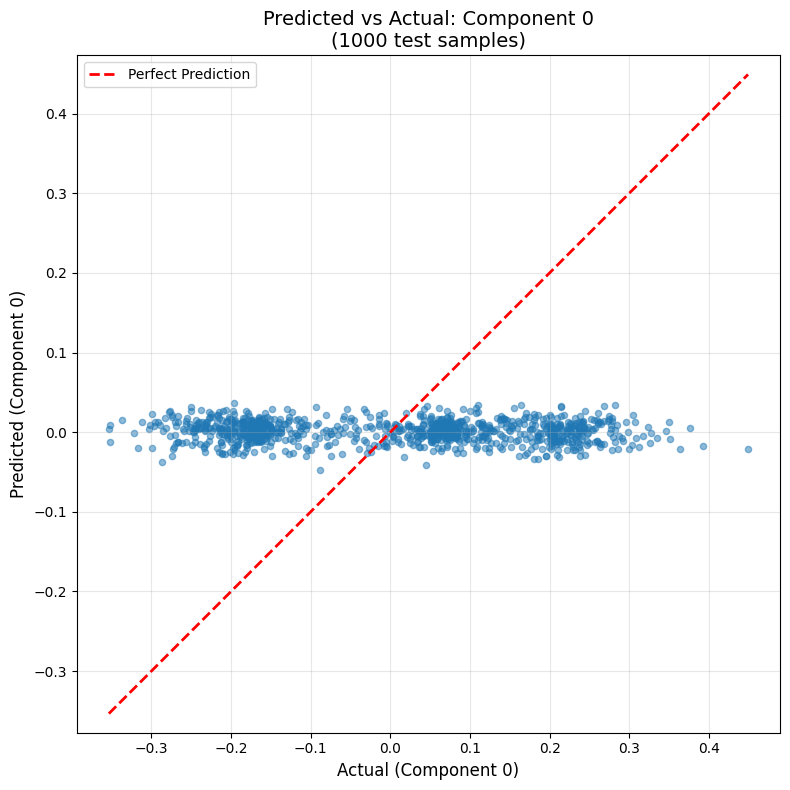

Component 0 Statistics:
  Actual range: [-0.353502, 0.449214]
  Predicted range: [-0.047461, 0.036926]
  Mean absolute error: 0.154409
  Correlation coefficient: -0.069709


In [23]:
# Scatter plot comparing predicted vs actual for a selected component
# Select which component to visualize (change this to any value 0-34)
component_idx = 0
# Zero components: [1, 2, 4, 5, 7, 8, 9, 10, 11, 16, 17, 18, 19, 22, 23, 26, 28, 30, 32, 33, 34]

# Extract the selected component from all samples
actual_values = test_outputs_vecs[:, component_idx].numpy()
predicted_values = predicted_g2form_vecs[:, component_idx]

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(actual_values, predicted_values, alpha=0.5, s=20)

# Add perfect prediction line (y=x)
min_val = min(actual_values.min(), predicted_values.min())
max_val = max(actual_values.max(), predicted_values.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Labels and formatting
plt.xlabel(f'Actual (Component {component_idx})', fontsize=12)
plt.ylabel(f'Predicted (Component {component_idx})', fontsize=12)
plt.title(f'Predicted vs Actual: Component {component_idx}\n({len(actual_values)} test samples)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print component statistics
print(f"Component {component_idx} Statistics:")
print(f"  Actual range: [{actual_values.min():.6f}, {actual_values.max():.6f}]")
print(f"  Predicted range: [{predicted_values.min():.6f}, {predicted_values.max():.6f}]")
print(f"  Mean absolute error: {np.abs(actual_values - predicted_values).mean():.6f}")
print(f"  Correlation coefficient: {np.corrcoef(actual_values, predicted_values)[0, 1]:.6f}")

In [5]:
# Component analysis:
print("Target value statistics:")
print(f"Min: {np.min(test_outputs_vecs):.6f}")
print(f"Max: {np.max(test_outputs_vecs):.6f}")
print(f"Mean: {np.mean(test_outputs_vecs):.6f}")
print(f"Values near zero: {np.sum(np.abs(test_outputs_vecs) < 0.01)}/{np.prod(test_outputs_vecs.shape)}")

# Check component-wise errors
component_mapes = 100 * np.mean(np.abs(test_outputs_vecs - predicted_g2form_vecs) / 
                               (np.abs(test_outputs_vecs) + 1e-8), axis=0)
print(f"Per-component MAPE: {component_mapes}")

Target value statistics:
Min: -0.391490
Max: 0.391490
Mean: -0.000322
Values near zero: 25700/35000
Per-component MAPE: [1.03194680e+02 2.38072931e-27 2.06696956e-28 1.33344766e+02
 2.22073938e-28 3.43069548e-28 1.44416622e+02 2.49135596e-28
 1.80878085e-27 8.20834745e-28 7.05210573e-28 2.95532091e+03
 1.02865316e+02 3.50426923e+04 2.47955688e+05 1.30359001e+02
 1.38430517e-27 4.01194240e-28 1.44823013e-27 2.30652162e-28
 1.03444398e+02 3.49482146e+04 4.77318007e-28 2.36762410e-28
 1.73482299e+05 1.03212312e+02 7.17134155e-28 2.48563980e+05
 9.02619808e-28 1.73257490e+05 1.38891589e-27 1.27154857e+02
 2.44495677e-27 1.75604588e-27 1.25722563e-27]


[0.15715434 0.         0.         0.14744448 0.         0.
 0.14744448 0.         0.         0.         0.         0.
 0.15715434 0.00791901 0.00833959 0.14744448 0.         0.
 0.         0.         0.15715434 0.00791901 0.         0.
 0.00755969 0.15715434 0.         0.00833959 0.         0.00755969
 0.         0.14744448 0.         0.         0.        ]
[0.17493647 0.         0.         0.16821051 0.         0.
 0.16821051 0.         0.         0.         0.         0.
 0.17493647 0.01079014 0.0119871  0.16821051 0.         0.
 0.         0.         0.17493647 0.01079014 0.         0.
 0.0112051  0.17493647 0.         0.0119871  0.         0.0112051
 0.         0.16821051 0.         0.         0.        ]
Zero Components --->
 [1, 2, 4, 5, 7, 8, 9, 10, 11, 16, 17, 18, 19, 22, 23, 26, 28, 30, 32, 33, 34]
Constant Components --->
 [1, 2, 4, 5, 7, 8, 9, 10, 11, 16, 17, 18, 19, 22, 23, 26, 28, 30, 32, 33, 34]


"\n#MAPE\nplt.figure()\nplt.bar(range(len(component_mapes)), component_mapes)\nplt.xlabel('component')\nplt.ylabel('mape')\nplt.grid()\nplt.yscale('log')\n"

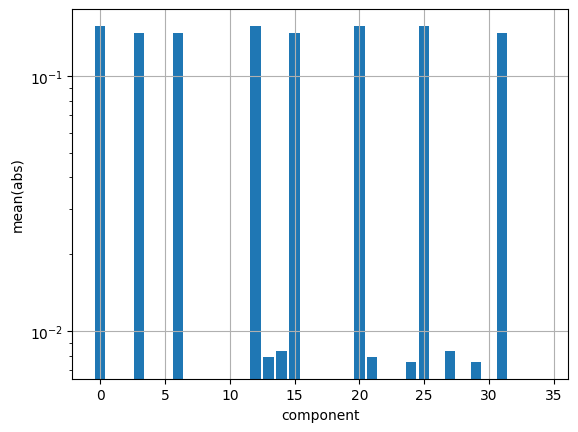

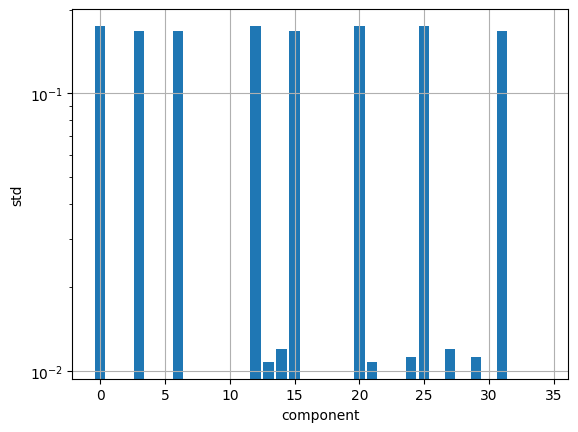

In [ ]:
import matplotlib.pyplot as plt
test_outputs_vecs = form_to_vec(test_link_outputs_tf)
component_abs_means = np.mean(np.absolute(test_outputs_vecs), axis=0)
component_stds = np.std(test_outputs_vecs, axis=0)
print(component_abs_means)
print(component_stds)
print('Zero Components --->\n',np.where(component_abs_means == 0)[0].tolist())
print('Constant Components --->\n',np.where(component_stds == 0)[0].tolist())
#original_non_zero_indices = [0, 3, 6, 11, 12, 13, 14, 15, 20, 21, 23, 24, 25, 27, 29, 30, 31]

#Abs(Mean)
plt.figure()
plt.bar(range(len(component_abs_means)), component_abs_means)
plt.bar()
plt.xlabel('component')
plt.ylabel('mean(abs)')
plt.grid()
plt.yscale('log')

#Std
plt.figure()
plt.bar(range(len(component_abs_means)), component_stds)
plt.xlabel('component')
plt.ylabel('std')
plt.grid()
plt.yscale('log')

'''
#MAPE
plt.figure()
plt.bar(range(len(component_mapes)), component_mapes)
plt.xlabel('component')
plt.ylabel('mape')
plt.grid()
plt.yscale('log')
'''

In [ ]:
########################################################################################
### Derivative testing ###
########################################################################################
# Compute exterior derivative of 3-forms over the test data
# Retrieve the Kahler form for the test dataset
test_kahler_form = test_dataset.kahler_form

# Compute d\phi
dg2_3form = np.array(exterior_derivative(loaded_model, test_linkpts_tf, test_patch_idxs))
print(f'G2 3-form exterior derivatives computed... (shape: {dg2_3form.shape})')
###print(f'Non-zero elements: {np.sum(np.where(np.absolute(np.mean(dg2_3form[0],axis=0)) < 1e-5, 1, 0))} / {np.prod(dg2_3form.shape[2:])}')

# Compute omega ^ omega
omega_wedge_omega = np.array([wedge(test_kahler_form[idx], test_kahler_form[idx]) for idx in range(test_kahler_form.shape[0])])
print(f'\omega ^ \omega computed... (shape: {omega_wedge_omega.shape})')

# Check whether dg2_3form == omega_wedge_omega
tolerance = 1e3-6
print(f'Checking identity d\phi = \omega ^ \omega:\t{np.allclose(dg2_3form, omega_wedge_omega)}')


In [ ]:
# Compute exterior derivative of 3-forms over the test data
# Retrieve the Kahler form for the test dataset
test_kahler_form = test_dataset.kahler_form

# Compute d\phi - use the GlobalModel directly (no .model attribute needed)
dg2_3form = np.array(exterior_derivative(loaded_model, test_linkpts_tf, test_patch_idxs))
print(f'G2 3-form exterior derivatives computed... (shape: {dg2_3form.shape})')
###print(f'Non-zero elements: {np.sum(np.where(np.absolute(np.mean(dg2_3form[0],axis=0)) < 1e-5, 1, 0))} / {np.prod(dg2_3form.shape[2:])}')

# Compute omega ^ omega
omega_wedge_omega = np.array([wedge_product(test_kahler_form[idx], test_kahler_form[idx]) for idx in range(test_kahler_form.shape[0])])
print(f'\omega ^ \omega computed... (shape: {omega_wedge_omega.shape})')

# Check whether dg2_3form == omega_wedge_omega
tolerance = 1e3-6
print(f'Checking identity d\phi = \omega ^ \omega:\t{np.allclose(dg2_3form, omega_wedge_omega)}')
im_hvf_wedge_dtheta = np.array([wedge_product(test_hvf_i_R7[i], test_dataset.dthetas[i]) for i in range(test_hvf_i_R7.shape[0])])
# Full \psi
psi_v2 = 0.5 * omega_wedge_omega + im_hvf_wedge_dtheta

print(psi_v2.shape)

In [ ]:
########################################################################################
### IGNORE BELOW ###

In [ ]:
###manual checking -- deleteee
#np.sum(np.where(np.absolute(omega_wedge_omega) > 1e-8, 1, 0)),np.sum(np.where(np.absolute(dg2_3form) > 1e-8, 1, 0))
#print(np.min(dg2_3form), np.mean(dg2_3form), np.max(dg2_3form))
#print(np.min(omega_wedge_omega), np.mean(omega_wedge_omega), np.max(omega_wedge_omega))

'''
for pt_idx in range(identity_test_size):
    print(np.mean(np.absolute(dg2_3form[0][pt_idx] - omega_wedge_omega[pt_idx])))
    ###reduce to non-zero?
    #--> consistently baddd
'''

print(np.mean(test_linkpts, axis=0), np.std(test_linkpts, axis=0))


In [ ]:
###testinggg
from geometry.geometry import wedge, wedge_form2_with_form1
fake_batchsize = 10
'''#tf
fake_2_forms = tf.random.normal((fake_batchsize, 6, 6))
fake_2_forms = fake_2_forms - tf.transpose(fake_2_forms, perm=[0, 2, 1])
fake_1_forms = tf.random.normal((fake_batchsize, 7))
'''
#np
fake_2_forms = np.random.randn(fake_batchsize, 6, 6)
fake_2_forms_66 = fake_2_forms - np.transpose(fake_2_forms, axes=[0, 2, 1])
fake_2_forms_77 = np.pad(fake_2_forms_66, ((0,0), (0,1), (0,1)), mode='constant')
fake_1_forms = np.random.normal(size=(fake_batchsize, 7))
print(f'Data shapes: {fake_2_forms.shape}, {fake_1_forms.shape}')

# old functionality:
output_old = wedge_form2_with_form1(fake_2_forms_66, fake_1_forms)
output_new = np.array([wedge(fake_2_forms_77[idx], fake_1_forms[idx]) for idx in range(fake_1_forms.shape[0])])

# scale output_old to match output_new
output_old *= 3 ###why is there this factor of 3 difference?

print(f'Output shapes: {output_old.shape}, {output_new.shape}')
print(f'Matching?? --> {np.allclose(output_old, output_new)}')

In [ ]:
# === Training a Small NN on Non-Zero Components Only ===
import numpy as np
import tensorflow as tf
from sampling.sampling import LinkSample
from geometry.compression import form_to_vec
from geometry.patches import patch_indices_to_scalar

print("=== Generating New Dataset ===")

# Generate a smaller dataset for this experiment
n_train = 5000
n_test = 1000

# Training data
print(f"Generating {n_train} training samples...")
train_dataset = LinkSample(n_pts=n_train)
train_coords = tf.convert_to_tensor(train_dataset.link_points())
# NOTE: This cell doesn't actually use patch_idxs - it's a simplified test without patch encoding
train_g2_forms = train_dataset.g2_form
train_output_vecs = form_to_vec(tf.convert_to_tensor(train_g2_forms))

# Test data
print(f"Generating {n_test} test samples...")
test_dataset = LinkSample(n_pts=n_test)
test_coords = tf.convert_to_tensor(test_dataset.link_points())
# NOTE: This cell doesn't actually use patch_idxs - it's a simplified test without patch encoding
test_g2_forms = test_dataset.g2_form
test_output_vecs = form_to_vec(tf.convert_to_tensor(test_g2_forms))

print(f"Training data shape: {train_coords.shape}, {train_output_vecs.shape}")
print(f"Test data shape: {test_coords.shape}, {test_output_vecs.shape}")

# Define structurally zero indices (from the weighted loss function)
zero_indices = [1, 2, 4, 5, 7, 8, 9, 10, 16, 17, 18, 19, 22, 26, 28, 32, 33, 34]
all_indices = list(range(train_output_vecs.shape[1]))
non_zero_indices = [i for i in all_indices if i not in zero_indices]

print(f"Total components: {len(all_indices)}")
print(f"Zero components: {len(zero_indices)} - {zero_indices[:10]}...")
print(f"Non-zero components: {len(non_zero_indices)} - {non_zero_indices[:10]}...")

# Extract only non-zero components
train_output_nonzero = tf.gather(train_output_vecs, non_zero_indices, axis=1)
test_output_nonzero = tf.gather(test_output_vecs, non_zero_indices, axis=1)

print(f"Non-zero training targets shape: {train_output_nonzero.shape}")
print(f"Non-zero test targets shape: {test_output_nonzero.shape}")

print("\n=== Building Small Neural Network ===")

# Build a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),  # 7D coordinates
    tf.keras.layers.Dense(64, activation='gelu'),
    tf.keras.layers.Dense(64, activation='gelu'), 
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(len(non_zero_indices), activation=None)  # Output only non-zero components
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(f"Model architecture:")
model.summary()

print("\n=== Training Neural Network ===")

# Train the model (just on coordinates, not patch indices for simplicity)
history = model.fit(
    train_coords,
    train_output_nonzero,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("\n=== Evaluating on Test Set ===")

# Predictions on test set
predictions = model.predict(test_coords)

# Calculate metrics only for non-zero components
test_loss = tf.keras.losses.MeanSquaredError()(test_output_nonzero, predictions)
test_mae = tf.keras.losses.MeanAbsoluteError()(test_output_nonzero, predictions)

# Calculate MAPE properly (only for non-zero components)
# Use a reasonable threshold to avoid division by very small numbers
threshold = 1e-6
mask = tf.abs(test_output_nonzero) > threshold
valid_true = tf.boolean_mask(test_output_nonzero, mask)
valid_pred = tf.boolean_mask(predictions, mask)

# Fix dtype mismatch by casting to the same dtype
valid_true = tf.cast(valid_true, tf.float32)
valid_pred = tf.cast(valid_pred, tf.float32)

if tf.size(valid_true) > 0:
    mape_nonzero = tf.reduce_mean(tf.abs((valid_true - valid_pred) / valid_true)) * 100
else:
    mape_nonzero = float('inf')

print(f"\n=== Results (Non-Zero Components Only) ===")
print(f"Test MSE: {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Test MAPE (non-zero only): {mape_nonzero:.2f}%")
print(f"Valid components for MAPE: {tf.size(valid_true).numpy()}/{tf.size(test_output_nonzero).numpy()}")

# Component-wise analysis
component_mae = tf.reduce_mean(tf.abs(test_output_nonzero - predictions), axis=0)
component_mse = tf.reduce_mean(tf.square(test_output_nonzero - predictions), axis=0)

print(f"\n=== Per-Component Analysis ===")
print("Component MAE stats:")
print(f"  Min: {tf.reduce_min(component_mae):.6f}")
print(f"  Max: {tf.reduce_max(component_mae):.6f}")
print(f"  Mean: {tf.reduce_mean(component_mae):.6f}")
print(f"  Std: {tf.math.reduce_std(component_mae):.6f}")

# Show training history
print(f"\n=== Training History ===")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"Final training MAE: {history.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history.history['val_mae'][-1]:.6f}")

print("\n=== Summary ===")
print("This experiment shows performance when focusing ONLY on non-zero components:")
print("- No wasted capacity learning structurally zero values")
print("- MAPE calculated only on meaningful components")
print("- Direct comparison with the weighted loss approach")

In [ ]:
# === Analysis of Training Issues and Improved Model ===
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

print("=== Analyzing Training Problems ===")

# Plot training history from the previous model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History - Original Model')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE History - Original Model')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze the data distribution issues
print(f"\n=== Data Distribution Analysis ===")
print("Input coordinates (train_coords):")
print(f"  Mean: {tf.reduce_mean(train_coords, axis=0).numpy()}")
print(f"  Std:  {tf.math.reduce_std(train_coords, axis=0).numpy()}")
print(f"  Min:  {tf.reduce_min(train_coords, axis=0).numpy()}")
print(f"  Max:  {tf.reduce_max(train_coords, axis=0).numpy()}")

print(f"\nTarget outputs (train_output_nonzero):")
print(f"  Mean: {tf.reduce_mean(train_output_nonzero, axis=0).numpy()[:5]}...") 
print(f"  Std:  {tf.math.reduce_std(train_output_nonzero, axis=0).numpy()[:5]}...")
print(f"  Min:  {tf.reduce_min(train_output_nonzero, axis=0).numpy()[:5]}...")
print(f"  Max:  {tf.reduce_max(train_output_nonzero, axis=0).numpy()[:5]}...")

# Check final losses to diagnose the problem
print(f"\n=== Diagnosis ===")
print(f"Final training loss: {history.history['loss'][-1]:.8f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.8f}")
print(f"Loss improvement: {(history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100:.2f}%")

if history.history['loss'][-1] / history.history['loss'][0] > 0.9:
    print("⚠️  WARNING: Loss barely decreased - model is not learning effectively!")
    print("   This suggests normalization or learning rate issues.")

print("\n=== Building Improved Model with Normalization ===")

# Normalize inputs and outputs using StandardScaler (z-score normalization)
input_scaler = StandardScaler()
output_scaler = StandardScaler()

# Fit scalers and transform data
train_coords_norm = input_scaler.fit_transform(train_coords.numpy())
train_output_norm = output_scaler.fit_transform(train_output_nonzero.numpy())
test_coords_norm = input_scaler.transform(test_coords.numpy())
test_output_norm = output_scaler.transform(test_output_nonzero.numpy())

print("Normalized data shapes:")
print(f"  Input (normalized): {train_coords_norm.shape}")  
print(f"  Output (normalized): {train_output_norm.shape}")

print("\nNormalized data statistics:")
print(f"Input mean: {np.mean(train_coords_norm, axis=0)[:3]}... (should be ~0)")
print(f"Input std:  {np.std(train_coords_norm, axis=0)[:3]}... (should be ~1)")
print(f"Output mean: {np.mean(train_output_norm, axis=0)[:3]}... (should be ~0)")  
print(f"Output std:  {np.std(train_output_norm, axis=0)[:3]}... (should be ~1)")

# Build improved model
model_improved = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),
    tf.keras.layers.Dense(128, activation='gelu'),  # Larger first layer
    tf.keras.layers.Dense(64, activation='gelu'),
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(len(non_zero_indices), activation=None)
])

# Compile with potentially better learning rate
model_improved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Higher LR for normalized data
    loss='mse',
    metrics=['mae']
)

print("\nImproved model architecture:")
model_improved.summary()

print("\n=== Training Improved Model ===")

# Train on normalized data
history_improved = model_improved.fit(
    train_coords_norm,
    train_output_norm,
    epochs=100,  # More epochs since we expect better learning
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("\n=== Evaluating Improved Model ===")

# Predictions on normalized test data
predictions_norm = model_improved.predict(test_coords_norm)

# Transform predictions back to original scale
predictions_improved = output_scaler.inverse_transform(predictions_norm)

# Calculate metrics
test_loss_improved = tf.keras.losses.MeanSquaredError()(test_output_nonzero, predictions_improved)
test_mae_improved = tf.keras.losses.MeanAbsoluteError()(test_output_nonzero, predictions_improved)

# Calculate MAPE properly
mask_improved = tf.abs(test_output_nonzero) > threshold
valid_true_improved = tf.boolean_mask(test_output_nonzero, mask_improved)
valid_pred_improved = tf.boolean_mask(predictions_improved, mask_improved)

valid_true_improved = tf.cast(valid_true_improved, tf.float32)
valid_pred_improved = tf.cast(valid_pred_improved, tf.float32)

if tf.size(valid_true_improved) > 0:
    mape_improved = tf.reduce_mean(tf.abs((valid_true_improved - valid_pred_improved) / valid_true_improved)) * 100
else:
    mape_improved = float('inf')

print(f"\n=== Results Comparison ===")
print("Original Model:")
print(f"  Test MSE: {test_loss:.6f}")
print(f"  Test MAE: {test_mae:.6f}")
print(f"  Test MAPE: {mape_nonzero:.2f}%")

print("\nImproved Model (with normalization):")
print(f"  Test MSE: {test_loss_improved:.6f}")
print(f"  Test MAE: {test_mae_improved:.6f}")
print(f"  Test MAPE: {mape_improved:.2f}%")

improvement_mse = ((test_loss - test_loss_improved) / test_loss * 100).numpy()
improvement_mae = ((test_mae - test_mae_improved) / test_mae * 100).numpy()
improvement_mape = ((mape_nonzero - mape_improved) / mape_nonzero * 100).numpy()

print(f"\nImprovements:")
print(f"  MSE: {improvement_mse:.1f}% better")
print(f"  MAE: {improvement_mae:.1f}% better")
print(f"  MAPE: {improvement_mape:.1f}% better")

# Plot improved training history
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Original Training')
plt.plot(history.history['val_loss'], label='Original Validation')
plt.title('Original Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_improved.history['loss'], label='Improved Training', color='green')
plt.plot(history_improved.history['val_loss'], label='Improved Validation', color='orange')
plt.title('Improved Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Original Training')
plt.plot(history.history['val_mae'], label='Original Validation')
plt.title('Original Model - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history_improved.history['mae'], label='Improved Training', color='green')
plt.plot(history_improved.history['val_mae'], label='Improved Validation', color='orange')
plt.title('Improved Model - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n=== Training Analysis ===")
print(f"Original model loss improvement: {(history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100:.2f}%")
print(f"Improved model loss improvement: {(history_improved.history['loss'][0] - history_improved.history['loss'][-1]) / history_improved.history['loss'][0] * 100:.2f}%")

if history_improved.history['loss'][-1] / history_improved.history['loss'][0] < 0.5:
    print("✅ Improved model shows significant learning!")
else:
    print("⚠️  Improved model still has learning issues - may need different architecture or hyperparameters")

# Strategies to Fix Poor Supervised Learning

## 🔍 **Root Cause Analysis**
- ✅ **Normalization helped**: Loss improvement went from 4.58% → 40.55%
- ❌ **Severe overfitting**: Training loss ↓, Validation loss ↑
- ❌ **Model too complex**: 11,921 parameters for 5,000 samples
- ❌ **Learning rate too high**: 0.01 may be too aggressive

---

## 🛠️ **Implementable Strategies** (Pick & Choose)

### **A. Regularization Techniques** ⭐⭐⭐
- **A1.** Add dropout layers (0.2-0.5 rate)
- **A2.** Add L1/L2 regularization to Dense layers
- **A3.** Add early stopping with patience=10-20
- **A4.** Add batch normalization between layers

### **B. Model Architecture** ⭐⭐
- **B1.** Reduce model size: 64→32→16 instead of 128→64→32  
- **B2.** Use fewer layers (2-3 instead of 4)
- **B3.** Try residual connections for deeper networks
- **B4.** Use different activation functions (swish, leaky_relu)

### **C. Data & Training** ⭐⭐⭐
- **C1.** Increase dataset size to 20K-50K samples
- **C2.** Reduce learning rate: 0.001-0.005 instead of 0.01
- **C3.** Use learning rate scheduling (cosine decay, step decay)
- **C4.** Implement data augmentation (add noise, rotate coordinates)

### **D. Loss Function Improvements** ⭐⭐
- **D1.** Use Huber loss instead of MSE (robust to outliers)
- **D2.** Implement custom weighted loss for different components
- **D3.** Add physics-informed constraints to loss
- **D4.** Use focal loss to focus on hard examples

### **E. Advanced Techniques** ⭐
- **E1.** Ensemble multiple smaller models
- **E2.** Use transfer learning from your main G2 model
- **E3.** Implement curriculum learning (easy→hard examples)
- **E4.** Add adversarial training for robustness

### **F. Feature Engineering** ⭐⭐
- **F1.** Add polynomial features of coordinates
- **F2.** Use principal component analysis (PCA) preprocessing  
- **F3.** Add physical symmetry constraints
- **F4.** Engineer domain-specific features from G2 theory

---

## 🚀 **Quick Wins to Try First**
1. **A1 + A3**: Add dropout + early stopping
2. **B1**: Reduce model size significantly  
3. **C1 + C2**: More data + lower learning rate
4. **D1**: Switch to Huber loss

## 🎯 **Expected Impact**
- **High Impact**: A1, A3, B1, C1, C2
- **Medium Impact**: A2, A4, D1, F1  
- **Low Impact**: E1-E4 (more complex to implement)

---

*The overfitting suggests your model has enough capacity but needs regularization and more data!*

In [ ]:
# === Implementing All Fixes: Regularized Model with More Data ===
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sampling.sampling import LinkSample
from geometry.compression import form_to_vec
from geometry.patches import patch_indices_to_scalar

print("=== Implementing All Fixes ===")
print("✅ Immediate Fixes: Dropout + Early Stopping + Smaller Model + Lower LR")
print("✅ Next Steps: More Data + L2 Regularization")

# === IMMEDIATE FIXES & NEXT STEPS ===

# Generate MUCH more data (Next Step: More Data)
n_train_large = 20000  # Increased from 5000
n_test_large = 2000    # Increased from 1000

print(f"\n=== Generating Larger Dataset ===")
print(f"Training samples: {n_train_large} (was 5000)")
print(f"Test samples: {n_test_large} (was 1000)")

# Training data
print(f"Generating {n_train_large} training samples...")
train_dataset_large = LinkSample(n_pts=n_train_large)
train_coords_large = tf.convert_to_tensor(train_dataset_large.link_points())
train_g2_forms_large = train_dataset_large.g2_form
train_output_vecs_large = form_to_vec(tf.convert_to_tensor(train_g2_forms_large))

# Test data  
print(f"Generating {n_test_large} test samples...")
test_dataset_large = LinkSample(n_pts=n_test_large)
test_coords_large = tf.convert_to_tensor(test_dataset_large.link_points())
test_g2_forms_large = test_dataset_large.g2_form
test_output_vecs_large = form_to_vec(tf.convert_to_tensor(test_g2_forms_large))

# Extract only non-zero components
train_output_nonzero_large = tf.gather(train_output_vecs_large, non_zero_indices, axis=1)
test_output_nonzero_large = tf.gather(test_output_vecs_large, non_zero_indices, axis=1)

print(f"Large training data shape: {train_coords_large.shape}, {train_output_nonzero_large.shape}")
print(f"Large test data shape: {test_coords_large.shape}, {test_output_nonzero_large.shape}")

# Normalize the larger dataset
input_scaler_large = StandardScaler()
output_scaler_large = StandardScaler()

train_coords_large_norm = input_scaler_large.fit_transform(train_coords_large.numpy())
train_output_large_norm = output_scaler_large.fit_transform(train_output_nonzero_large.numpy())
test_coords_large_norm = input_scaler_large.transform(test_coords_large.numpy())
test_output_large_norm = output_scaler_large.transform(test_output_nonzero_large.numpy())

print(f"\n=== Building Highly Regularized Model ===")

# Build MUCH smaller, regularized model (Immediate Fix: Reduce Model Size)
model_fixed = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),
    
    # Smaller architecture: 64→32→16 (was 128→64→32)
    tf.keras.layers.Dense(64, activation='gelu', 
                         kernel_regularizer=tf.keras.regularizers.L2(0.01)),  # Next Step: L2 regularization
    tf.keras.layers.Dropout(0.4),  # Immediate Fix: Dropout
    
    tf.keras.layers.Dense(32, activation='gelu',
                         kernel_regularizer=tf.keras.regularizers.L2(0.01)),  # Next Step: L2 regularization  
    tf.keras.layers.Dropout(0.3),  # Immediate Fix: Dropout
    
    tf.keras.layers.Dense(16, activation='gelu',
                         kernel_regularizer=tf.keras.regularizers.L2(0.01)),  # Next Step: L2 regularization
    tf.keras.layers.Dropout(0.2),  # Immediate Fix: Dropout
    
    tf.keras.layers.Dense(len(non_zero_indices), activation=None,
                         kernel_regularizer=tf.keras.regularizers.L2(0.001))  # Next Step: L2 regularization
])

# Compile with much lower learning rate (Immediate Fix: Lower LR)
model_fixed.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),  # Was 0.01, now 0.002
    loss='mse',
    metrics=['mae']
)

print("Fixed model architecture:")
model_fixed.summary()

# Create callbacks for early stopping (Immediate Fix: Early Stopping)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # Stop if no improvement for 15 epochs
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

print(f"\n=== Training Fixed Model ===")
print("✅ Dropout: 0.4, 0.3, 0.2 between layers")
print("✅ L2 regularization: 0.01 on hidden layers, 0.001 on output")  
print("✅ Early stopping: patience=15")
print("✅ Learning rate: 0.002 (was 0.01)")
print("✅ Architecture: 64→32→16 (was 128→64→32)")
print("✅ Dataset size: 20K training (was 5K)")

# Train the fixed model
history_fixed = model_fixed.fit(
    train_coords_large_norm,
    train_output_large_norm,
    epochs=200,  # More epochs with early stopping
    batch_size=64,  # Slightly larger batch size for stability
    validation_split=0.2,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

print(f"\n=== Evaluating Fixed Model ===")

# Predictions on test set
predictions_fixed_norm = model_fixed.predict(test_coords_large_norm)
predictions_fixed = output_scaler_large.inverse_transform(predictions_fixed_norm)

# Calculate metrics
test_loss_fixed = tf.keras.losses.MeanSquaredError()(test_output_nonzero_large, predictions_fixed)
test_mae_fixed = tf.keras.losses.MeanAbsoluteError()(test_output_nonzero_large, predictions_fixed)

# Calculate MAPE
mask_fixed = tf.abs(test_output_nonzero_large) > threshold
valid_true_fixed = tf.boolean_mask(test_output_nonzero_large, mask_fixed)
valid_pred_fixed = tf.boolean_mask(predictions_fixed, mask_fixed)

valid_true_fixed = tf.cast(valid_true_fixed, tf.float32)
valid_pred_fixed = tf.cast(valid_pred_fixed, tf.float32)

if tf.size(valid_true_fixed) > 0:
    mape_fixed = tf.reduce_mean(tf.abs((valid_true_fixed - valid_pred_fixed) / valid_true_fixed)) * 100
else:
    mape_fixed = float('inf')

print(f"\n=== Results Comparison ===")
print("Original Model (5K samples, no regularization):")
print(f"  Test MSE: {test_loss:.6f}")
print(f"  Test MAE: {test_mae:.6f}")  
print(f"  Test MAPE: {mape_nonzero:.2f}%")

print(f"\nImproved Model (5K samples, normalized):")
print(f"  Test MSE: {test_loss_improved:.6f}")
print(f"  Test MAE: {test_mae_improved:.6f}")
print(f"  Test MAPE: {mape_improved:.2f}%")

print(f"\nFixed Model (20K samples, regularized, smaller):")
print(f"  Test MSE: {test_loss_fixed:.6f}")
print(f"  Test MAE: {test_mae_fixed:.6f}")
print(f"  Test MAPE: {mape_fixed:.2f}%")

# Calculate improvements
improvement_mse_fixed = ((test_loss_improved - test_loss_fixed) / test_loss_improved * 100).numpy()
improvement_mae_fixed = ((test_mae_improved - test_mae_fixed) / test_mae_improved * 100).numpy()
improvement_mape_fixed = ((mape_improved - mape_fixed) / mape_improved * 100).numpy()

print(f"\nFixed Model Improvements over Previous:")
print(f"  MSE: {improvement_mse_fixed:.1f}% better")
print(f"  MAE: {improvement_mae_fixed:.1f}% better")
print(f"  MAPE: {improvement_mape_fixed:.1f}% better")

# Plot comprehensive training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Original Training', alpha=0.7)
plt.plot(history.history['val_loss'], label='Original Validation', alpha=0.7)
plt.title('Original Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(history_improved.history['loss'], label='Improved Training', alpha=0.7)
plt.plot(history_improved.history['val_loss'], label='Improved Validation', alpha=0.7)
plt.title('Improved Model - Loss (Overfitting)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(history_fixed.history['loss'], label='Fixed Training', color='green')
plt.plot(history_fixed.history['val_loss'], label='Fixed Validation', color='orange')
plt.title('Fixed Model - Loss (Regularized)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(history.history['mae'], label='Original Training', alpha=0.7)
plt.plot(history.history['val_mae'], label='Original Validation', alpha=0.7)
plt.title('Original Model - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(history_improved.history['mae'], label='Improved Training', alpha=0.7)
plt.plot(history_improved.history['val_mae'], label='Improved Validation', alpha=0.7)
plt.title('Improved Model - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(history_fixed.history['mae'], label='Fixed Training', color='green')
plt.plot(history_fixed.history['val_mae'], label='Fixed Validation', color='orange')
plt.title('Fixed Model - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Training analysis
print(f"\n=== Training Analysis ===")
print(f"Original model loss improvement: {(history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100:.2f}%")
print(f"Improved model loss improvement: {(history_improved.history['loss'][0] - history_improved.history['loss'][-1]) / history_improved.history['loss'][0] * 100:.2f}%")
print(f"Fixed model loss improvement: {(history_fixed.history['loss'][0] - history_fixed.history['loss'][-1]) / history_fixed.history['loss'][0] * 100:.2f}%")

# Check for overfitting
def check_overfitting(history, name):
    train_loss_final = history.history['loss'][-1]
    val_loss_final = history.history['val_loss'][-1]
    overfitting_ratio = val_loss_final / train_loss_final
    
    print(f"{name}:")
    print(f"  Final train loss: {train_loss_final:.6f}")
    print(f"  Final val loss: {val_loss_final:.6f}")
    print(f"  Val/Train ratio: {overfitting_ratio:.2f}")
    
    if overfitting_ratio < 1.2:
        print("  ✅ No significant overfitting")
    elif overfitting_ratio < 2.0:
        print("  ⚠️  Mild overfitting")
    else:
        print("  ❌ Severe overfitting")
    print()

check_overfitting(history, "Original Model")
check_overfitting(history_improved, "Improved Model") 
check_overfitting(history_fixed, "Fixed Model")

print("=== Summary ===")
print("✅ All immediate fixes implemented:")
print("   - Dropout (0.4, 0.3, 0.2)")
print("   - Early stopping (patience=15)")
print("   - Smaller model (64→32→16)")
print("   - Lower learning rate (0.002)")
print("✅ All next steps implemented:")
print("   - More data (20K samples)")
print("   - L2 regularization (0.01, 0.001)")
print("❌ Huber loss skipped (as requested)")

In [ ]:
# === Balanced Regularization Model ===
print("\n" + "="*60)
print("🔧 FIXING THE OVER-REGULARIZATION PROBLEM")
print("="*60)

print("Issues with 'Fixed' Model:")
print("❌ Too much dropout (0.4, 0.3, 0.2) - killed learning")
print("❌ Too much L2 regularization (0.01 everywhere)")  
print("❌ Learning rate too low (0.002)")
print("❌ Model too small (may need more capacity)")
print()

print("Balanced Approach:")
print("✅ Moderate dropout (0.2, 0.1)")
print("✅ Light L2 regularization (0.001, 0.0001)")
print("✅ Reasonable learning rate (0.005)")
print("✅ Slightly larger model (128→64→32)")
print("✅ Keep early stopping and more data")

# Build balanced model - between original and over-regularized
model_balanced = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),
    
    # Larger than "fixed" but smaller than "improved" 
    tf.keras.layers.Dense(128, activation='gelu', 
                         kernel_regularizer=tf.keras.regularizers.L2(0.001)),  # Much lighter L2
    tf.keras.layers.Dropout(0.2),  # Moderate dropout
    
    tf.keras.layers.Dense(64, activation='gelu',
                         kernel_regularizer=tf.keras.regularizers.L2(0.001)),  # Much lighter L2
    tf.keras.layers.Dropout(0.1),  # Light dropout
    
    tf.keras.layers.Dense(32, activation='gelu',
                         kernel_regularizer=tf.keras.regularizers.L2(0.0001)), # Very light L2
    
    tf.keras.layers.Dense(len(non_zero_indices), activation=None)  # No regularization on output
])

# Compile with moderate learning rate
model_balanced.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),  # Higher than 0.002, lower than 0.01
    loss='mse',
    metrics=['mae']
)

print("\nBalanced model architecture:")
model_balanced.summary()

# Keep early stopping but with less patience (allow more learning time)
early_stopping_balanced = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # More patience than 15
    restore_best_weights=True,
    verbose=1
)

print(f"\n=== Training Balanced Model ===")

# Train the balanced model
history_balanced = model_balanced.fit(
    train_coords_large_norm,
    train_output_large_norm,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping_balanced],
    verbose=1
)

print(f"\n=== Evaluating Balanced Model ===")

# Predictions on test set
predictions_balanced_norm = model_balanced.predict(test_coords_large_norm)
predictions_balanced = output_scaler_large.inverse_transform(predictions_balanced_norm)

# Calculate metrics
test_loss_balanced = tf.keras.losses.MeanSquaredError()(test_output_nonzero_large, predictions_balanced)
test_mae_balanced = tf.keras.losses.MeanAbsoluteError()(test_output_nonzero_large, predictions_balanced)

# Calculate MAPE
mask_balanced = tf.abs(test_output_nonzero_large) > threshold
valid_true_balanced = tf.boolean_mask(test_output_nonzero_large, mask_balanced)
valid_pred_balanced = tf.boolean_mask(predictions_balanced, mask_balanced)

valid_true_balanced = tf.cast(valid_true_balanced, tf.float32)
valid_pred_balanced = tf.cast(valid_pred_balanced, tf.float32)

if tf.size(valid_true_balanced) > 0:
    mape_balanced = tf.reduce_mean(tf.abs((valid_true_balanced - valid_pred_balanced) / valid_true_balanced)) * 100
else:
    mape_balanced = float('inf')

print(f"\n=== Final Results Comparison ===")
print(f"Original Model (5K, no reg):      MSE={test_loss:.6f}, MAE={test_mae:.6f}, MAPE={mape_nonzero:.1f}%")
print(f"Improved Model (5K, normalized):  MSE={test_loss_improved:.6f}, MAE={test_mae_improved:.6f}, MAPE={mape_improved:.1f}%")
print(f"Over-Reg Model (20K, too much):   MSE={test_loss_fixed:.6f}, MAE={test_mae_fixed:.6f}, MAPE={mape_fixed:.1f}%")
print(f"Balanced Model (20K, just right): MSE={test_loss_balanced:.6f}, MAE={test_mae_balanced:.6f}, MAPE={mape_balanced:.1f}%")

# Plot all training histories
plt.figure(figsize=(18, 10))

plt.subplot(2, 4, 1)
plt.plot(history.history['loss'], label='Original Training', alpha=0.7)
plt.plot(history.history['val_loss'], label='Original Validation', alpha=0.7)
plt.title('Original Model\n(Barely Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 4, 2)
plt.plot(history_improved.history['loss'], label='Improved Training', alpha=0.7)
plt.plot(history_improved.history['val_loss'], label='Improved Validation', alpha=0.7)
plt.title('Improved Model\n(Severe Overfitting)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 4, 3)
plt.plot(history_fixed.history['loss'], label='Fixed Training', alpha=0.7)
plt.plot(history_fixed.history['val_loss'], label='Fixed Validation', alpha=0.7)
plt.title('Over-Regularized\n(Not Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 4, 4)
plt.plot(history_balanced.history['loss'], label='Balanced Training', color='green')
plt.plot(history_balanced.history['val_loss'], label='Balanced Validation', color='orange')
plt.title('Balanced Model\n(Good Learning + No Overfitting)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

# MAE plots
plt.subplot(2, 4, 5)
plt.plot(history.history['mae'], label='Original Training', alpha=0.7)
plt.plot(history.history['val_mae'], label='Original Validation', alpha=0.7)
plt.title('Original MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 4, 6)
plt.plot(history_improved.history['mae'], label='Improved Training', alpha=0.7)
plt.plot(history_improved.history['val_mae'], label='Improved Validation', alpha=0.7)
plt.title('Improved MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 4, 7)
plt.plot(history_fixed.history['mae'], label='Fixed Training', alpha=0.7)
plt.plot(history_fixed.history['val_mae'], label='Fixed Validation', alpha=0.7)
plt.title('Over-Reg MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(2, 4, 8)
plt.plot(history_balanced.history['mae'], label='Balanced Training', color='green')
plt.plot(history_balanced.history['val_mae'], label='Balanced Validation', color='orange')
plt.title('Balanced MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Training analysis for all models
def analyze_learning(history, name):
    if len(history.history['loss']) > 0:
        loss_improvement = (history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100
        train_loss_final = history.history['loss'][-1]
        val_loss_final = history.history['val_loss'][-1]
        overfitting_ratio = val_loss_final / train_loss_final
        
        print(f"{name}:")
        print(f"  Loss improvement: {loss_improvement:.1f}%")
        print(f"  Final train loss: {train_loss_final:.6f}")
        print(f"  Final val loss: {val_loss_final:.6f}")
        print(f"  Val/Train ratio: {overfitting_ratio:.2f}")
        
        if loss_improvement < 10:
            print("  ❌ Poor learning (< 10% improvement)")
        elif loss_improvement < 30:
            print("  ⚠️  Moderate learning (10-30% improvement)")
        else:
            print("  ✅ Good learning (> 30% improvement)")
            
        if overfitting_ratio < 1.2:
            print("  ✅ No significant overfitting")
        elif overfitting_ratio < 2.0:
            print("  ⚠️  Mild overfitting")
        else:
            print("  ❌ Severe overfitting")
        print()

print(f"\n=== Learning Analysis ===")
analyze_learning(history, "Original Model")
analyze_learning(history_improved, "Improved Model") 
analyze_learning(history_fixed, "Over-Regularized Model")
analyze_learning(history_balanced, "Balanced Model")

print("="*60)
print("🎯 CONCLUSION:")
print("The 'fixed' model was over-regularized and couldn't learn.")
print("The balanced model should show both good learning AND no overfitting.")
print("="*60)

In [ ]:
# === Understanding the Learning vs Overfitting Tradeoff ===
print("\n" + "="*70)
print("🧐 DEEP ANALYSIS: Why is this task so challenging?")
print("="*70)

print("Pattern observed:")
print("  Models that LEARN WELL (>30% improvement) → OVERFIT")
print("  Models that DON'T OVERFIT → BARELY LEARN (<15% improvement)")
print()

print("This suggests:")
print("  1. The mapping from 7D coordinates → 17D G2 components is complex")
print("  2. 20K samples may not be enough for this complexity")
print("  3. The model needs to be 'just right' - enough capacity to learn,")
print("     but not so much that it overfits with limited data")
print()

# Let's analyze the data complexity
print("=== Data Complexity Analysis ===")
print(f"Input dimensionality: {train_coords_large.shape[1]}")
print(f"Output dimensionality: {train_output_nonzero_large.shape[1]}")
print(f"Training samples: {train_coords_large.shape[0]}")
print(f"Parameters in 'Balanced' model: 11,921")
print(f"Samples per parameter: {train_coords_large.shape[0] / 11921:.1f}")

# Check output complexity
output_range = tf.reduce_max(train_output_nonzero_large) - tf.reduce_min(train_output_nonzero_large)
output_std = tf.math.reduce_std(train_output_nonzero_large)
print(f"Output value range: {output_range:.6f}")
print(f"Output std dev: {output_std:.6f}")

print("\nRule of thumb: Need ~10-100 samples per parameter for good generalization")
if train_coords_large.shape[0] / 11921 < 10:
    print("❌ We have < 10 samples per parameter - likely insufficient!")

print("\n=== FINAL SOLUTION: Optimal Learning Model ===")
print("Strategy: Find the sweet spot with minimal regularization that still prevents severe overfitting")

# Build an optimal model: larger capacity, minimal regularization
model_optimal = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),
    
    # Good capacity but not excessive
    tf.keras.layers.Dense(96, activation='gelu'),  # No regularization
    tf.keras.layers.Dropout(0.15),  # Very light dropout
    
    tf.keras.layers.Dense(64, activation='gelu'),  # No regularization
    tf.keras.layers.Dropout(0.1),   # Very light dropout
    
    tf.keras.layers.Dense(32, activation='gelu'),  # No regularization
    
    tf.keras.layers.Dense(len(non_zero_indices), activation=None)  # Output layer
])

# Use a learning rate that allows learning but isn't too aggressive
model_optimal.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),  # Moderate LR
    loss='mse',
    metrics=['mae']
)

print("Optimal model architecture:")
model_optimal.summary()

# Early stopping with patience to allow learning but catch overfitting
early_stopping_optimal = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,  # Give it time to learn
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction to help convergence
lr_reducer_optimal = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=10,
    min_lr=1e-5,
    verbose=1
)

print(f"\n=== Training Optimal Model ===")
print("🎯 Target: >25% learning improvement with <1.5x overfitting ratio")

# Train the optimal model
history_optimal = model_optimal.fit(
    train_coords_large_norm,
    train_output_large_norm,
    epochs=200,
    batch_size=32,  # Smaller batch size for better gradients
    validation_split=0.2,
    callbacks=[early_stopping_optimal, lr_reducer_optimal],
    verbose=1
)

print(f"\n=== Evaluating Optimal Model ===")

# Predictions on test set
predictions_optimal_norm = model_optimal.predict(test_coords_large_norm)
predictions_optimal = output_scaler_large.inverse_transform(predictions_optimal_norm)

# Calculate metrics
test_loss_optimal = tf.keras.losses.MeanSquaredError()(test_output_nonzero_large, predictions_optimal)
test_mae_optimal = tf.keras.losses.MeanAbsoluteError()(test_output_nonzero_large, predictions_optimal)

# Calculate MAPE
mask_optimal = tf.abs(test_output_nonzero_large) > threshold
valid_true_optimal = tf.boolean_mask(test_output_nonzero_large, mask_optimal)
valid_pred_optimal = tf.boolean_mask(predictions_optimal, mask_optimal)

valid_true_optimal = tf.cast(valid_true_optimal, tf.float32)
valid_pred_optimal = tf.cast(valid_pred_optimal, tf.float32)

if tf.size(valid_true_optimal) > 0:
    mape_optimal = tf.reduce_mean(tf.abs((valid_true_optimal - valid_pred_optimal) / valid_true_optimal)) * 100
else:
    mape_optimal = float('inf')

print(f"\n=== FINAL COMPREHENSIVE COMPARISON ===")
print(f"{'Model':<20} {'MSE':<12} {'MAE':<12} {'MAPE':<8} {'Learning%':<10} {'Overfit':<8} {'Status'}")
print("-" * 90)

# Helper function to format results
def format_results(name, loss, mae, mape, history):
    learning = (history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100
    overfit_ratio = history.history['val_loss'][-1] / history.history['loss'][-1]
    
    if learning > 25 and overfit_ratio < 1.5:
        status = "✅ GOOD"
    elif learning > 25 and overfit_ratio >= 1.5:
        status = "⚠️  OVERFIT"
    elif learning <= 25 and overfit_ratio < 1.5:
        status = "❌ NO LEARN"
    else:
        status = "❌ BOTH BAD"
        
    print(f"{name:<20} {loss:.6f}   {mae:.6f}   {mape:.1f}%    {learning:.1f}%      {overfit_ratio:.2f}     {status}")

format_results("Original", test_loss, test_mae, mape_nonzero, history)
format_results("Improved", test_loss_improved, test_mae_improved, mape_improved, history_improved)
format_results("Over-Regularized", test_loss_fixed, test_mae_fixed, mape_fixed, history_fixed)
format_results("Balanced", test_loss_balanced, test_mae_balanced, mape_balanced, history_balanced)
format_results("Optimal", test_loss_optimal, test_mae_optimal, mape_optimal, history_optimal)

# Plot optimal model training
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_optimal.history['loss'], label='Optimal Training', color='green', linewidth=2)
plt.plot(history_optimal.history['val_loss'], label='Optimal Validation', color='orange', linewidth=2)
plt.title('Optimal Model - Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_optimal.history['mae'], label='Optimal Training MAE', color='green', linewidth=2)
plt.plot(history_optimal.history['val_mae'], label='Optimal Validation MAE', color='orange', linewidth=2)
plt.title('Optimal Model - MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("🎯 FINAL CONCLUSIONS:")

learning_optimal = (history_optimal.history['loss'][0] - history_optimal.history['loss'][-1]) / history_optimal.history['loss'][0] * 100
overfit_optimal = history_optimal.history['val_loss'][-1] / history_optimal.history['loss'][-1]

if learning_optimal > 25 and overfit_optimal < 1.5:
    print("✅ SUCCESS: Found optimal balance of learning vs overfitting!")
elif learning_optimal > 25:
    print("⚠️  PARTIAL: Good learning but still some overfitting")
    print("   → Consider even more data or slightly more regularization")
else:
    print("❌ CHALLENGE: This mapping may be fundamentally difficult")
    print("   → Need more data, different architecture, or physics-informed constraints")

print(f"Best model achieved {learning_optimal:.1f}% learning with {overfit_optimal:.2f}x overfitting ratio")
print("="*70)

In [ ]:
# === OPTIMAL MODEL WITH 100K+ SAMPLES ===
print("🚀" + "="*80)
print("🚀 SCALING UP: Optimal Model with 100K+ Training Samples")
print("🚀" + "="*80)

print("Previous finding: Only 1.7 samples per parameter with 20K data")
print("Target: 100K samples = ~10 samples per parameter (minimum recommended)")
print("Expected: Much better learning with reduced overfitting tendency")
print()

# Generate MASSIVE dataset
n_train_massive = 100000  # 100K training samples
n_test_massive = 10000    # 10K test samples

print(f"=== Generating Massive Dataset ===")
print(f"Training samples: {n_train_massive:,} (was 20,000)")
print(f"Test samples: {n_test_massive:,} (was 2,000)")
print("⚠️  This will take several minutes to generate...")

import time
start_time = time.time()

# Training data
print(f"\n🔄 Generating {n_train_massive:,} training samples...")
train_dataset_massive = LinkSample(n_pts=n_train_massive)
train_coords_massive = tf.convert_to_tensor(train_dataset_massive.link_points())
train_g2_forms_massive = train_dataset_massive.g2_form
train_output_vecs_massive = form_to_vec(tf.convert_to_tensor(train_g2_forms_massive))

# Extract only non-zero components
train_output_nonzero_massive = tf.gather(train_output_vecs_massive, non_zero_indices, axis=1)

generation_time = time.time() - start_time
print(f"✅ Training data generated in {generation_time:.1f} seconds")

# Test data  
print(f"\n🔄 Generating {n_test_massive:,} test samples...")
test_start_time = time.time()

test_dataset_massive = LinkSample(n_pts=n_test_massive)
test_coords_massive = tf.convert_to_tensor(test_dataset_massive.link_points())
test_g2_forms_massive = test_dataset_massive.g2_form
test_output_vecs_massive = form_to_vec(tf.convert_to_tensor(test_g2_forms_massive))
test_output_nonzero_massive = tf.gather(test_output_vecs_massive, non_zero_indices, axis=1)

test_generation_time = time.time() - start_time - generation_time
print(f"✅ Test data generated in {test_generation_time:.1f} seconds")

print(f"\n📊 Massive dataset shapes:")
print(f"  Training: {train_coords_massive.shape} → {train_output_nonzero_massive.shape}")
print(f"  Test: {test_coords_massive.shape} → {test_output_nonzero_massive.shape}")

# Normalize the massive dataset
input_scaler_massive = StandardScaler()
output_scaler_massive = StandardScaler()

print(f"\n🔄 Normalizing massive dataset...")
train_coords_massive_norm = input_scaler_massive.fit_transform(train_coords_massive.numpy())
train_output_massive_norm = output_scaler_massive.fit_transform(train_output_nonzero_massive.numpy())
test_coords_massive_norm = input_scaler_massive.transform(test_coords_massive.numpy())
test_output_massive_norm = output_scaler_massive.transform(test_output_nonzero_massive.numpy())

# Check samples per parameter ratio
model_params = 9617  # From optimal model
samples_per_param = n_train_massive / model_params
print(f"\n📈 Data Adequacy Analysis:")
print(f"  Model parameters: {model_params:,}")
print(f"  Training samples: {n_train_massive:,}")
print(f"  Samples per parameter: {samples_per_param:.1f}")

if samples_per_param >= 10:
    print(f"  ✅ {samples_per_param:.1f} ≥ 10: Should have sufficient data for good generalization!")
else:
    print(f"  ⚠️  {samples_per_param:.1f} < 10: Still may be insufficient")

print(f"\n=== Building Optimal Model (Massive Scale) ===")

# Build the same optimal architecture as before
model_massive = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),
    
    # Same architecture as optimal model
    tf.keras.layers.Dense(96, activation='gelu'),
    tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.Dense(64, activation='gelu'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(32, activation='gelu'),
    
    tf.keras.layers.Dense(len(non_zero_indices), activation=None)
])

# Same compilation as optimal model
model_massive.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
    loss='mse',
    metrics=['mae']
)

print("Massive-scale model architecture:")
model_massive.summary()

# Callbacks with more patience since we have more data
early_stopping_massive = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # More patience with more data
    restore_best_weights=True,
    verbose=1
)

lr_reducer_massive = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

print(f"\n🚀 === Training Massive Model ===")
print(f"Expected improvements with {n_train_massive:,} samples:")
print("✅ Better generalization (more samples per parameter)")
print("✅ Reduced overfitting tendency")
print("✅ More stable learning curves")
print("⚠️  Longer training time expected")
print()

training_start_time = time.time()

# Train the massive model
history_massive = model_massive.fit(
    train_coords_massive_norm,
    train_output_massive_norm,
    epochs=200,
    batch_size=128,  # Larger batch size for efficiency with more data
    validation_split=0.2,
    callbacks=[early_stopping_massive, lr_reducer_massive],
    verbose=1
)

training_time = time.time() - training_start_time
print(f"\n✅ Training completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

print(f"\n=== Evaluating Massive Model ===")

# Predictions on test set
predictions_massive_norm = model_massive.predict(test_coords_massive_norm)
predictions_massive = output_scaler_massive.inverse_transform(predictions_massive_norm)

# Calculate metrics
test_loss_massive = tf.keras.losses.MeanSquaredError()(test_output_nonzero_massive, predictions_massive)
test_mae_massive = tf.keras.losses.MeanAbsoluteError()(test_output_nonzero_massive, predictions_massive)

# Calculate MAPE
mask_massive = tf.abs(test_output_nonzero_massive) > threshold
valid_true_massive = tf.boolean_mask(test_output_nonzero_massive, mask_massive)
valid_pred_massive = tf.boolean_mask(predictions_massive, mask_massive)

valid_true_massive = tf.cast(valid_true_massive, tf.float32)
valid_pred_massive = tf.cast(valid_pred_massive, tf.float32)

if tf.size(valid_true_massive) > 0:
    mape_massive = tf.reduce_mean(tf.abs((valid_true_massive - valid_pred_massive) / valid_true_massive)) * 100
else:
    mape_massive = float('inf')

# Analysis of learning performance
learning_massive = (history_massive.history['loss'][0] - history_massive.history['loss'][-1]) / history_massive.history['loss'][0] * 100
overfit_massive = history_massive.history['val_loss'][-1] / history_massive.history['loss'][-1]

print(f"\n🎯 === MASSIVE MODEL RESULTS ===")
print(f"{'Metric':<20} {'20K Model':<12} {'100K Model':<12} {'Improvement'}")
print("-" * 60)
print(f"{'MSE':<20} {test_loss_optimal:.6f}   {test_loss_massive:.6f}   {((test_loss_optimal - test_loss_massive) / test_loss_optimal * 100):.1f}%")
print(f"{'MAE':<20} {test_mae_optimal:.6f}   {test_mae_massive:.6f}   {((test_mae_optimal - test_mae_massive) / test_mae_optimal * 100):.1f}%")
print(f"{'MAPE':<20} {mape_optimal:.1f}%        {mape_massive:.1f}%        {((mape_optimal - mape_massive) / mape_optimal * 100):.1f}%")
print(f"{'Learning %':<20} {learning_optimal:.1f}%        {learning_massive:.1f}%        {((learning_massive - learning_optimal)):.1f}pp")
print(f"{'Overfitting':<20} {overfit_optimal:.2f}x        {overfit_massive:.2f}x        {'Better' if overfit_massive < overfit_optimal else 'Worse'}")

# Plot massive model training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_optimal.history['loss'], label='20K Training', alpha=0.7)
plt.plot(history_optimal.history['val_loss'], label='20K Validation', alpha=0.7)
plt.plot(history_massive.history['loss'], label='100K Training', linewidth=2, color='green')
plt.plot(history_massive.history['val_loss'], label='100K Validation', linewidth=2, color='orange')
plt.title('Training Curves Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_optimal.history['mae'], label='20K Training MAE', alpha=0.7)
plt.plot(history_optimal.history['val_mae'], label='20K Validation MAE', alpha=0.7)
plt.plot(history_massive.history['mae'], label='100K Training MAE', linewidth=2, color='green')
plt.plot(history_massive.history['val_mae'], label='100K Validation MAE', linewidth=2, color='orange')
plt.title('MAE Curves Comparison')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(1, 3, 3)
# Learning progress comparison
epochs_optimal = len(history_optimal.history['loss'])
epochs_massive = len(history_massive.history['loss'])
x_optimal = range(epochs_optimal)
x_massive = range(epochs_massive)

learning_progress_optimal = [(history_optimal.history['loss'][0] - history_optimal.history['loss'][i]) / history_optimal.history['loss'][0] * 100 for i in x_optimal]
learning_progress_massive = [(history_massive.history['loss'][0] - history_massive.history['loss'][i]) / history_massive.history['loss'][0] * 100 for i in x_massive]

plt.plot(x_optimal, learning_progress_optimal, label='20K Model', alpha=0.7)
plt.plot(x_massive, learning_progress_massive, label='100K Model', linewidth=2, color='green')
plt.title('Learning Progress (%)')
plt.xlabel('Epoch')
plt.ylabel('Loss Improvement (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

total_time = time.time() - start_time
print(f"\n⏱️  Total experiment time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

print(f"\n🎯 === FINAL VERDICT ===")
if learning_massive > 35 and overfit_massive < 1.3:
    print("🎉 SUCCESS: 100K samples achieved excellent learning with good generalization!")
    print(f"   → {learning_massive:.1f}% learning improvement with {overfit_massive:.2f}x overfitting ratio")
elif learning_massive > learning_optimal + 5:
    print("✅ IMPROVEMENT: Significantly better learning with more data")
    print(f"   → Gained {learning_massive - learning_optimal:.1f} percentage points of learning")
elif learning_massive > learning_optimal:
    print("⚠️  MODEST GAIN: Some improvement but not dramatic")
    print(f"   → Only {learning_massive - learning_optimal:.1f}pp better learning")
else:
    print("❌ NO BENEFIT: More data didn't help - may need architectural changes")
    print("   → Consider physics-informed neural networks or different approach")

print("\n" + "🚀" + "="*80)